In [315]:
import torch
import torch.nn as nn
from torch.distributions import Normal, MixtureSameFamily, Categorical, Dirichlet, Independent

In [316]:
from src.environment import NormalMoveEnv
from src.experiment import Trajectory

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline

<AxesSubplot: >

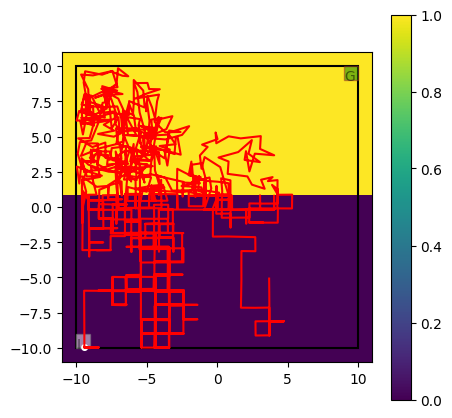

In [317]:
env_params = {
    'walls': [],
    'goals': [([9.,9.],[10.,10.])],
    'start': ([-10.,-10.],[-9.,-9.]),
}

# sigma=(.01, .3), 
# tau=(1., -1.), 

env = NormalMoveEnv(**env_params)

s = env.reset()

t = Trajectory(env, size=1_000)
ax = t.plot(env.plot())
ax

In [318]:
t.run

,step,s,a,r,s_,end
0,1.0,"[-9.397704597308595, -9.972126452840078]",0.0,1.0,"[-8.389391, -9.958774]",0.0
0,2.0,"[-8.389391, -9.958774]",1.0,1.0,"[-9.412888, -9.967251]",0.0
0,3.0,"[-9.412888, -9.967251]",1.0,1.0,"[-9.412888, -9.967251]",0.0
0,4.0,"[-9.412888, -9.967251]",0.0,1.0,"[-8.410064, -9.975485]",0.0
0,5.0,"[-8.410064, -9.975485]",1.0,1.0,"[-9.420308, -9.972015]",0.0
...,...,...,...,...,...,...
0,996.0,"[3.7233407, -8.1147]",0.0,1.0,"[4.722313, -8.101111]",0.0
0,997.0,"[4.722313, -8.101111]",1.0,1.0,"[3.715742, -8.096556]",0.0
0,998.0,"[3.715742, -8.096556]",2.0,1.0,"[3.7118576, -7.0949078]",0.0
0,999.0,"[3.7118576, -7.0949078]",2.0,1.0,"[3.703414, -6.096055]",0.0


<AxesSubplot: >

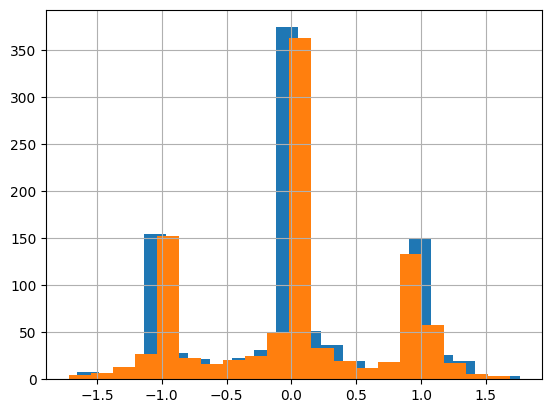

In [319]:
dist = t.run.copy()
## dist['move'] = np.linalg.norm(np.stack(t.run.s_.values) - np.stack(t.run.s.values), axis=1)
dist['move_id'] = np.sum(np.stack(t.run.s_.values) - np.stack(t.run.s.values), axis=1)
dist['move'] = t.run.s_.values - t.run.s.values
dist['move_x'] = np.stack(t.run.s_.values)[:,0] - np.stack(t.run.s.values)[:,0]
dist['move_y'] = np.stack(t.run.s_.values)[:,1] - np.stack(t.run.s.values)[:,1]
# dist.move.hist(bins=20)
dist.move_x.hist(bins=20)
dist.move_y.hist(bins=20)

# Mixture of Gaussianas

$ x \sim N(\mu, \Sigma)$ 

$ z \sim Categorical(k, \phi) \; where \; \phi_j>=0, and \sum_{j=1}^k{\phi_j} = 1 $ 

$l(\phi, \mu, \Sigma) = \sum_{i=1}^m{log \; p(x^{(i)}|z^{(i)};\mu,\Sigma) + log \; p(z^{(i)}; \phi)}$


In [320]:
# k = 5

# mix = Categorical(torch.ones(k))
# comp = Normal(torch.randn(k), torch.exp(torch.randn(k)))
# gmm = MixtureSameFamily(mix, comp)
# # torch.exp(gmm.log_prob(X))
# probs = torch.exp(gmm.component_distribution.log_prob(torch.tensor(dist.move.to_numpy()).reshape(-1,1)))
# torch.sum(probs, axis=0)

In [321]:
d = 2 # Dimensions 
k = 5 # N of Gasussians

mix = Categorical(torch.ones(k))
comp = Independent(Normal(torch.randn((k, d)), torch.exp(torch.randn((k, d)))), 1)
gmm = MixtureSameFamily(mix, comp)

probs = torch.exp(gmm.component_distribution.log_prob(torch.tensor(np.stack(dist.move.values)).reshape((-1,1,d))))
torch.sum(probs, axis=0)

tensor([ 5.8901, 26.5585, 57.8788, 32.8038, 37.5000], dtype=torch.float64)

# Expectation Maximization

### 1. Expectation

$w_j^{(i)} = p(z^{(i)} = j | x^{(i)}; \phi, \mu, \Sigma ) = \frac{p(x^{(i)}|z^{(i)}=j; \mu,\Sigma) p(z^{(i)}=j;\phi)}{\sum_{l=1}^k{p(x^{(i)}|z^{(i)}=l; \mu, \Sigma)p(z^{(i)}=l;\phi)}}$

### 2. Maximization

$\phi_j = \frac{1}{m}\sum_{i=1}^m{w_j^{(i)}}$  

$\mu_j = \frac{\sum_{i=1}^m{w_j^{(i)}}x^{(i)}}{\sum_{i=1}^m{w_j^{(i)}}}$ 

$\Sigma_j = \frac{\sum_{i=1}^m{w_j^{(i)}(x^{(i)}-\mu_j)^2}}{\sum_{i=1}^m{w_j^{(i)}}}$ 

## 1D

In [322]:
# from tqdm import tqdm
def expctation_maximization(data, iterations=100, k=3):
    classes = Dirichlet(torch.ones(k)).sample((1,)).flatten()
    mus = torch.rand(k)
    sigmas = torch.rand(k)

    X = torch.tensor(data).reshape(-1,1)
    m = data.shape[0]
    mix = Categorical(classes)
 
    for i in range(iterations):
        comp = Normal(mus, torch.clamp(sigmas, min=1e-5*torch.ones(k)))
        gmm = MixtureSameFamily(mix, comp)
        # Expectation
        comp_dist = gmm.mixture_distribution.probs
        comp_probs = torch.exp(gmm.component_distribution.log_prob(X))
        resps = (comp_dist*comp_probs) / torch.sum(comp_dist*comp_probs, axis=1).reshape((-1,1))
       
        # Maximization
        mix = Categorical((1/m) * torch.sum(resps, axis=0))
        mus = torch.sum(resps*X, axis=0) / torch.sum(resps, axis=0)
        sigmas = torch.sqrt(torch.sum(resps*((X-mus)**2), axis=0) / torch.sum(resps, axis=0))


    return mix.probs, mus, sigmas

expctation_maximization(
    data=dist.move_id.to_numpy(),
    iterations=1000,
    k=3
)

(tensor([0.2617, 0.2914, 0.4469], dtype=torch.float64),
 tensor([-1.0003,  1.0005, -0.0264], dtype=torch.float64),
 tensor([0.0148, 0.0139, 0.9899], dtype=torch.float64))

## n-D

In [377]:
# from tqdm import tqdm
def expctation_maximization(data, iterations=100, k=3):
    m,d = data.shape
    classes = Dirichlet(torch.ones(k)).sample((1,)).flatten()
    mus = torch.rand((k,d))
    sigmas = torch.rand((k,d))

    # X = torch.tensor(data).reshape(-1,1)
    X = torch.tensor(data).reshape((m,d))
    mix = Categorical(classes)
 
    for i in range(iterations):
        comp = Independent(Normal(mus, torch.clamp(sigmas, min=1e-5*torch.ones((k,d)))), 1)
        gmm = MixtureSameFamily(mix, comp)
        # Expectation
        comp_dist = gmm.mixture_distribution.probs
        comp_probs = torch.exp(gmm.component_distribution.log_prob(X.reshape((m,1,d))))
        resps = (comp_dist*comp_probs) / torch.sum(comp_dist*comp_probs, axis=1).reshape((-1,1))
       
        # Maximization
        mix = Categorical((1/m) * torch.sum(resps, axis=0))
        for j in range(k):
            mus[j] = torch.sum(resps[:,j].reshape(-1,1)*X, axis=0) / torch.sum(resps[:,j], axis=0)
            sigmas[j] = torch.sqrt(torch.sum(resps[:,j].reshape(-1,1)*((X-mus[j])**2), axis=0) / torch.sum(resps[:,j]))

    return mix.probs, mus, sigmas

probs, mus, sigs = expctation_maximization(
    data=np.stack(dist.move.values),
    iterations=5000,
    k=9
)

print('class_probs: ',torch.round(probs, decimals=3))
print('Mus: ', torch.round(mus, decimals=2))
print('Sigmas: ', torch.round(sigs, decimals=2))

class_probs:  tensor([0.1190, 0.0090, 0.0810, 0.1170, 0.0980, 0.1530, 0.1740, 0.1160, 0.1330],
       dtype=torch.float64)
Mus:  tensor([[ 0.0000, -1.0000],
        [-0.0000,  0.8600],
        [-0.0100,  1.0100],
        [-0.9600,  0.0100],
        [ 1.0500, -0.0400],
        [-0.0000,  1.0000],
        [-0.6600, -0.0000],
        [ 0.0500, -1.0100],
        [ 1.0000,  0.0000]])
Sigmas:  tensor([[0.0100, 0.0100],
        [0.1600, 0.0400],
        [0.3300, 0.3000],
        [0.2600, 0.2900],
        [0.3000, 0.3200],
        [0.0100, 0.0100],
        [0.4900, 0.0100],
        [0.2500, 0.2800],
        [0.0100, 0.0100]])


# Adaptação para MDP

$ \Delta_t = s_t - s_{t-1}$

$ \hat{\Delta}_t^j = f(s_t,a_t | \theta^j)$

Gaussian Softmax Function:

$p(z_t=j;s_t,a_t) = \frac{e^{-\frac{1}{2\sigma^2}(\Delta_t - \hat{\Delta}^j_t)^2}}{\sum_{l=1}^K{e^{-\frac{1}{2\sigma^2}(\Delta_t - \hat{\Delta}^l_t)^2}}}$

E-Step:

$w_t^{j} = p(z_t = j | \Delta_t, s_t, a_t; \mu, \Sigma ) = \frac{p(\Delta_t|z_t=j; \mu^j,\Sigma^j) p(z_t=j;s_t,a_t)}{\sum_{l=1}^k{p(\Delta_t|z_t=l; \mu^l, \Sigma^l)p(z_t=l; s_t,a_t)}} = \frac{p(\Delta_t|z_t=j; \mu^j,\Sigma^j) e^{-\frac{1}{2\sigma^2}(\Delta_t-\hat{\Delta}^j_t)^2}}{\sum_{l=1}^k{p(\Delta_t|z_t=l; \mu^l, \Sigma^l)e^{-\frac{1}{2\sigma^2}(\Delta_t-\hat{\Delta}^l_t)^2}}}$

M-Step:

$\theta^j = \theta^j - \alpha \nabla \sum_{t=1}^m(\Delta_t - f(s_t,a_t|\theta^j))$  

$\mu^j = \frac{\sum_{t=1}^m{w_t^j}\Delta_t}{\sum_{t=1}^m{w_t^j}}$ 

$\Sigma^j = \frac{\sum_{t=1}^m{w_t^j(\Delta_t-\mu_j)^2}}{\sum_{t=1}^m{w_t^j}}$ 

In [91]:

X = np.array([1., 0., -1.])
x_ = np.array([1.1, .05, -.8])

z = X - x_

d = np.std(X)

np.e**-(1/(2*d) * z**2) / np.sum(np.e**-(1/(2*d) * z**2))

array([0.33485134, 0.33639278, 0.32875589])

In [102]:
s = np.array([5.1, 6.1, 6.1])
a = np.array([1., 0., -1.])
s_ = np.array([6.1, 6.1, 5.1])

def f(s,a, ruido=2):
    return s+a + np.random.rand()*ruido

X = s_ - s
x_ = f(s, a)

std = np.std(X)

def pdf(x, mu, std):
    return (1/(std * (2*np.pi)**.5)) *  np.e**-(1/(2*std**2) * (x-mu)**2)
def soft(pred, std):
    return np.e**-(1/(2*std**2) * (X - pred)**2)


mu = np.random.rand(3)
var = np.random.rand(3)**2

w = (pdf(X, mu, var)*soft(x_, var)) / np.sum(pdf(X, mu, var)*soft(x_, var))

mu = (w*X) / np.sum(w)
var = (w*(X-mu)) / np.sum(w)

In [935]:
import torch

# Definindo a matriz (10, 2)
A = torch.tensor([[1., 2.], [3., 4.], [5., 6.], [7., 8.], [9., 10.],
                  [11., 12.], [13., 14.], [15., 16.], [17., 18.], [19., 20.]], requires_grad=True)

# Definindo a matriz (10, 9, 2)
B = torch.randn(10, 9, 2)

# Adicionando uma dimensão extra para a matriz A
A_expanded = A.unsqueeze(1)  # Agora tem o formato (10, 1, 2)

# Subtraindo as matrizes
result = B - A_expanded

result = A.unsqueeze(1) - B

# Definindo uma função de perda
loss = result.sum()

# Calculando o gradiente
loss.backward()

# Verificando o gradiente de A
print(A.grad)


tensor([[9., 9.],
        [9., 9.],
        [9., 9.],
        [9., 9.],
        [9., 9.],
        [9., 9.],
        [9., 9.],
        [9., 9.],
        [9., 9.],
        [9., 9.]])


In [955]:
def expctation_maximization(s, a, s_, f, iterations=100, k=3, lr=1e-4, momentum=.9):
    data = s_ - s
    m,d = data.shape
    
    theta = torch.nn.Parameter(
        10*torch.stack((torch.rand(k), 5*torch.exp(torch.rand(k)))).type(torch.DoubleTensor)
    )
    mus = torch.rand((k,d))
    sigmas = torch.rand((k,d))
    
    X = torch.tensor(data).reshape((m,d))
    # std = torch.std(X)

    def loss(actual, pred):
        # return ((actual.repeat(1,k)-pred.reshape(-1,2*k))**2).reshape(-1,k,2)
        return ((actual.unsqueeze(1)-pred)**2)
        # return torch.sum((actual-pred)**2, axis=2)
    def soft(err):
        return torch.exp(-(1/(2*torch.std(err, axis=2)**2) * torch.sum(err, axis=2)))

    optim = torch.optim.SGD([theta], lr=lr, momentum=momentum)
    for i in range(iterations):
        # print(i)
        optim.zero_grad()

        x_ = f(torch.tensor(s), torch.tensor(a), theta)
        err = loss(X, x_)
        mix = Categorical(torch.nan_to_num(torch.exp(torch.sum(torch.log(soft(err)),axis=0))))
        comp = Independent(Normal(torch.nan_to_num(mus), torch.clamp(torch.nan_to_num(sigmas), min=1e-5*torch.ones((k,d)))), 1)
        
        gmm = MixtureSameFamily(mix, comp)

        # Expectation
        comp_dist = gmm.mixture_distribution.probs
        comp_probs = torch.exp(gmm.component_distribution.log_prob(X.reshape((m,1,d))))
        W = (torch.clamp(comp_dist, min=1e-5)*comp_probs) / torch.sum(comp_dist*comp_probs, axis=1).reshape((-1,1))
       
        # Maximization
        ##  atualiza theta
        torch.sum(err).backward()
        optim.step() 
        ##

        mus = (torch.matmul(W.T, X).T / torch.sum(W, axis=0)).T
        sigmas = (torch.sqrt(torch.matmul(W.T, torch.sum(X.unsqueeze(1)-mus, axis=1)**2)).T / torch.sum(W, axis=0)).T

        # for j in range(k):
        #     mus[j] = torch.sum(W[:,j].reshape(-1,1)*X, axis=0) / torch.sum(W[:,j], axis=0)
        #     sigmas[j] = torch.sqrt(torch.sum(W[:,j].reshape(-1,1)*((X-mus[j])**2), axis=0) / torch.sum(W[:,j]))

    return theta, mus, sigmas



probs, mus, sigs = expctation_maximization(
    s=np.stack(dist.s.values),
    a=dist.a.values,
    s_=np.stack(dist.s_.values),
    # f=lambda s,a, params: torch.round(s) - s + params[:, a.type(torch.IntTensor), :],
    f=lambda s,a, params: Normal(*torch.unbind(params)).sample(s.shape).transpose(1,2).requires_grad_(),
    iterations=100,
    k=9
)

print('class_probs: ',torch.round(probs, decimals=2))
print('Mus: ', torch.round(mus, decimals=2))
print('Sigmas: ', torch.round(sigs, decimals=2))

class_probs:  tensor([[  6.3300,   9.2000,   1.3800,   0.4300,   8.3400,   3.1200,   5.5700,
           7.4600,   4.0000],
        [ 59.3000, 109.2200,  98.3300, 119.3000,  97.3200,  63.7100, 106.7500,
         127.8700,  89.0700]], dtype=torch.float64, grad_fn=<RoundBackward1>)
Mus:  tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], dtype=torch.float64, grad_fn=<RoundBackward1>)
Sigmas:  tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], dtype=torch.float64, grad_fn=<RoundBackward1>)


In [408]:
# def expctation_maximization(s, a, s_, f, iterations=100, k=3, lr=1e-4, momentum=.9):
#     data = s_ - s
#     m,d = data.shape
    
#     theta = [torch.nn.Parameter(torch.rand((np.unique(a).size, d)).type(torch.DoubleTensor)) for _ in range(k)]
#     mus = torch.rand((k,d))
#     sigmas = torch.rand((k,d))
    
#     X = torch.tensor(data).reshape((m,d))
#     # std = torch.std(X)

#     def loss(pred, actual):
#         return torch.sum((actual-pred)**2)
#     def soft(pred, std):
#         return torch.exp(-(1/(2*std**2) * (X - pred)**2))

#     optims = [torch.optim.SGD([theta[j]], lr=lr, momentum=momentum) for j in range(k)]
#     for i in range(iterations):
#         for j in range(k):
#             optims[j].zero_grad()

#             x_ = f(torch.tensor(s), torch.tensor(a), theta[j])
#             err = loss(x_,X)
#             mix = Categorical(torch.exp(torch.sum(torch.log(soft(x_, torch.std(err))),axis=0)))
#             comp = Independent(Normal(mus, torch.clamp(sigmas, min=1e-5*torch.ones((k,d)))), 1)
            
#             gmm = MixtureSameFamily(mix, comp)

#             # Expectation
#             comp_dist = gmm.mixture_distribution.probs
#             comp_probs = torch.exp(gmm.component_distribution.log_prob(X.reshape((m,1,d))))
#             W = (comp_dist*comp_probs) / torch.sum(comp_dist*comp_probs, axis=1).reshape((-1,1))
        
#             # Maximization
#             ##  atualiza theta
#             err.backward()
#             optims[j].step() 
#         ##
#             mus[j] = torch.sum(W[:,j].reshape(-1,1)*X, axis=0) / torch.sum(W[:,j], axis=0)
#             sigmas[j] = torch.sqrt(torch.sum(W[:,j].reshape(-1,1)*((X-mus[j])**2), axis=0) / torch.sum(W[:,j]))

#     return theta, mus, sigmas

# probs, mus, sigs = expctation_maximization(
#     s=np.stack(dist.s.values),
#     a=dist.a.values,
#     s_=np.stack(dist.s_.values),
#     f=lambda s,a, params: torch.round(s)-s + params[a.type(torch.IntTensor)],
#     iterations=5000,
#     k=9
# )

# # print('class_probs: ',torch.round(probs, decimals=3))
# print('Mus: ', torch.round(mus, decimals=2))
# print('Sigmas: ', torch.round(sigs, decimals=2))

$\mu^j = \frac{\sum_{t=1}^m{w_t^j}\Delta_t}{\sum_{t=1}^m{w_t^j}}$ 

$\Sigma^j = \frac{\sum_{t=1}^m{w_t^j(\Delta_t-\mu_j)^2}}{\sum_{t=1}^m{w_t^j}}$ 

In [1106]:
d = 0
j=0
mu_0_0 = (W[0][j]*X[0][d] + W[1][j]*X[1][d] + W[2][j]*X[2][d] + W[3][j]*X[3][d]) / (W[0][j] + W[1][j] + W[2][j] + W[3][j])
j=1
mu_0_1 = (W[0][j]*X[0][d] + W[1][j]*X[1][d] + W[2][j]*X[2][d] + W[3][j]*X[3][d]) / (W[0][j] + W[1][j] + W[2][j] + W[3][j])
j=2
mu_0_2 = (W[0][j]*X[0][d] + W[1][j]*X[1][d] + W[2][j]*X[2][d] + W[3][j]*X[3][d]) / (W[0][j] + W[1][j] + W[2][j] + W[3][j])

d = 1
j=0
mu_1_0 = (W[0][j]*X[0][d] + W[1][j]*X[1][d] + W[2][j]*X[2][d] + W[3][j]*X[3][d]) / (W[0][j] + W[1][j] + W[2][j] + W[3][j])
j=1
mu_1_1 = (W[0][j]*X[0][d] + W[1][j]*X[1][d] + W[2][j]*X[2][d] + W[3][j]*X[3][d]) / (W[0][j] + W[1][j] + W[2][j] + W[3][j])
j=2
mu_1_2 = (W[0][j]*X[0][d] + W[1][j]*X[1][d] + W[2][j]*X[2][d] + W[3][j]*X[3][d]) / (W[0][j] + W[1][j] + W[2][j] + W[3][j])

mus = torch.tensor([[mu_0_0,mu_1_0], [mu_0_1,mu_1_1], [mu_0_2,mu_1_2]])
mus

tensor([[4.6667, 5.6667],
        [4.3636, 5.3636],
        [4.1538, 5.1538]])

In [1107]:
d = 0
j=0
sig_0_0 = (W[0][j]*(X[0][d]-mus[j][0])**2 + W[1][j]*(X[1][d]-mus[j][0])**2 + W[2][j]*(X[2][d]-mus[j][0])**2 + W[3][j]*(X[3][d])-mus[j][0])**2 / (W[0][j] + W[1][j] + W[2][j] + W[3][j])
j=1
sig_0_1 = (W[0][j]*(X[0][d]-mus[j][0])**2 + W[1][j]*(X[1][d]-mus[j][0])**2 + W[2][j]*(X[2][d]-mus[j][0])**2 + W[3][j]*(X[3][d])-mus[j][0])**2 / (W[0][j] + W[1][j] + W[2][j] + W[3][j])
j=2
sig_0_2 = (W[0][j]*(X[0][d]-mus[j][0])**2 + W[1][j]*(X[1][d]-mus[j][0])**2 + W[2][j]*(X[2][d]-mus[j][0])**2 + W[3][j]*(X[3][d])-mus[j][0])**2 / (W[0][j] + W[1][j] + W[2][j] + W[3][j])

d = 1
j=0
sig_1_0 = (W[0][j]*(X[0][d]-mus[j][1])**2 + W[1][j]*(X[1][d]-mus[j][1])**2 + W[2][j]*(X[2][d]-mus[j][1])**2 + W[3][j]*(X[3][d])-mus[j][1])**2 / (W[0][j] + W[1][j] + W[2][j] + W[3][j])
j=1
sig_1_1 = (W[0][j]*(X[0][d]-mus[j][1])**2 + W[1][j]*(X[1][d]-mus[j][1])**2 + W[2][j]*(X[2][d]-mus[j][1])**2 + W[3][j]*(X[3][d])-mus[j][1])**2 / (W[0][j] + W[1][j] + W[2][j] + W[3][j])
j=2
sig_1_2 = (W[0][j]*(X[0][d]-mus[j][1])**2 + W[1][j]*(X[1][d]-mus[j][1])**2 + W[2][j]*(X[2][d]-mus[j][1])**2 + W[3][j]*(X[3][d])-mus[j][1])**2 / (W[0][j] + W[1][j] + W[2][j] + W[3][j])

sig = torch.tensor([[sig_0_0,sig_1_0], [sig_0_1,sig_1_1], [sig_0_2,sig_1_2]])
sig

tensor([[298.7655, 367.5062],
        [436.1038, 519.9269],
        [551.4455, 647.3992]])

In [1108]:
print(X[0][0], mus[0][0])
print(X[1][0], mus[0][0])
print(X[2][0], mus[0][0])
print(X[3][0], mus[0][0])

print(X[0][0]-mus[0][0])
print(X[1][0]-mus[0][0])
print(X[2][0]-mus[0][0])
print(X[3][0]-mus[0][0])
print('----')
print(X[0][0]-mus[0][0] + X[1][0]-mus[0][0] + X[2][0]-mus[0][0] + X[3][0]-mus[0][0])


tensor(0.) tensor(4.6667)
tensor(2.) tensor(4.6667)
tensor(4.) tensor(4.6667)
tensor(6.) tensor(4.6667)
tensor(-4.6667)
tensor(-2.6667)
tensor(-0.6667)
tensor(1.3333)
----
tensor(-6.6667)


In [1109]:
print(X.shape)
print(X)
print(mus.shape)
print(mus)


torch.Size([4, 2])
tensor([[0., 1.],
        [2., 3.],
        [4., 5.],
        [6., 7.]])
torch.Size([3, 2])
tensor([[4.6667, 5.6667],
        [4.3636, 5.3636],
        [4.1538, 5.1538]])


In [1110]:
(X.unsqueeze(1)-mus)

tensor([[[-4.6667, -4.6667],
         [-4.3636, -4.3636],
         [-4.1538, -4.1538]],

        [[-2.6667, -2.6667],
         [-2.3636, -2.3636],
         [-2.1538, -2.1538]],

        [[-0.6667, -0.6667],
         [-0.3636, -0.3636],
         [-0.1538, -0.1538]],

        [[ 1.3333,  1.3333],
         [ 1.6364,  1.6364],
         [ 1.8462,  1.8462]]])

In [1131]:
W.T

tensor([[ 0.,  3.,  6.,  9.],
        [ 1.,  4.,  7., 10.],
        [ 2.,  5.,  8., 11.]])

In [1151]:
torch.einsum('ij, xyz->ijxyz', W.T, (X.unsqueeze(1)-mus)).shape
# torch.einsum('jl, ijk->ikl', W.T, (X.unsqueeze(1)-mus)).sum(axis=2)

torch.Size([3, 4, 4, 3, 2])

In [1152]:
11*1 + 12*2 + 13*3 + 14*4

130

In [1122]:
torch.matmul(W.T, (X.unsqueeze(1)-mus))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x3 and 4x3)

In [1105]:
X = torch.tensor([[0.,1.], [2.,3.], [4.,5.], [6.,7.]])
W = torch.tensor([[0.,1.,2.], [3.,4.,5.], [6.,7.,8.], [9.,10.,11.]])
# muss = torch.tensor([[0.,1.], [3.,4.], [6.,7.]])
sigmas = torch.tensor([[0.,1.], [3.,4.], [6.,7.]])

mus1 = (torch.matmul(W.T, X).T / torch.sum(W, axis=0)).T
sigmas1 = (torch.sqrt(torch.matmul(W.T, torch.sum(X.unsqueeze(1)-mus1, axis=0)**2)).T / torch.sum(W, axis=0)).T

print(mus1)
print(sigmas1)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x4 and 3x2)

In [936]:
p = torch.stack((torch.tensor([1., 10, 5]), torch.tensor([.2, 3, .1])))

# print(p.shape)


s = torch.tensor([[0,0],[0,1],[0,1],[0,0],[0,1],[0,1]])
m = (s[:,1]>=1).type(torch.IntTensor)
a = torch.tensor([0,3,1,2,1,1]).type(torch.IntTensor)

p[:,1]
Normal(*torch.unbind(p)).sample(s.shape).transpose(1, 2).requires_grad_()#.reshape(*s.shape, 3)

tensor([[[ 0.7814,  0.8167],
         [11.6935,  9.7625],
         [ 4.9086,  5.0023]],

        [[ 0.9617,  1.0862],
         [ 7.3649, 15.8827],
         [ 4.9771,  5.1048]],

        [[ 1.1690,  0.6413],
         [ 9.3086, 10.4604],
         [ 5.0899,  5.0536]],

        [[ 0.7910,  1.2183],
         [ 9.9319, 14.3835],
         [ 4.8694,  5.0722]],

        [[ 1.1155,  1.3268],
         [11.9377,  9.2890],
         [ 4.9471,  4.8819]],

        [[ 0.9630,  1.1544],
         [10.0442,  8.2117],
         [ 4.9993,  5.0803]]], requires_grad=True)